<a href="https://colab.research.google.com/github/karencfisher/COVID19/blob/main/covidradio_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'
!unzip -q /content/drive/MyDrive/COVID-19_Radiography_Dataset/data.zip

!wget https://raw.githubusercontent.com/karencfisher/COVID19/main/ClaheDataGenerator.py

Mounted at /content/drive
--2021-08-22 01:51:42--  https://raw.githubusercontent.com/karencfisher/COVID19/main/ClaheDataGenerator.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3066 (3.0K) [text/plain]
Saving to: ‘ClaheDataGenerator.py’

ClaheDataGenerator. 100%[===================>]   2.99K  --.-KB/s    in 0s      

2021-08-22 01:51:42 (35.5 MB/s) - ‘ClaheDataGenerator.py’ saved [3066/3066]



In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from ClaheDataGenerator import ClahedDataGenerator


#### Get metadata on training set 

In [4]:
classes = ('normal', 'COVID')
data_path = 'data'

counts = []
filelists = []
for item in classes:
    filelist = os.listdir(os.path.join(data_path, 'train', item))
    filelists.append(filelist)
    counts.append(len(filelist))


#### Visualize samples of the image data by class

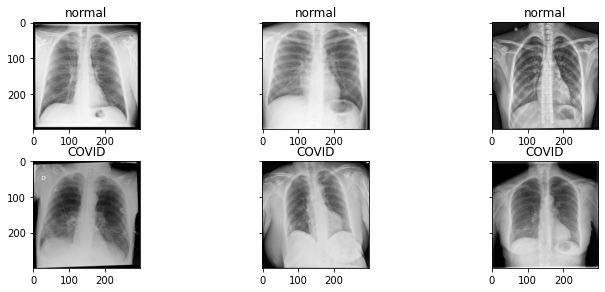

In [5]:
f, axes = plt.subplots(len(classes), 3, sharey=True)
f.set_figwidth(10)
plt.tight_layout()

for i, item in enumerate(classes):
    images = random.sample(filelists[i], 3)
    for j, image in enumerate(images):
        img_file = os.path.join(data_path, 'train', item, image)
        img = plt.imread(img_file)
        axes[i][j].imshow(img, cmap='gray')
        axes[i][j].set_title(item)


#### Plot prevalence of classes

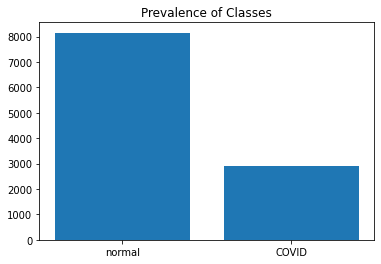

In [6]:
plt.bar(classes, counts)
plt.title('Prevalence of Classes');

#### Preprocessing step to enhance the images
CLAHE (Contrast Limited Adaptive Histogram Equalization)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def preprocess(img):
  img_gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img_gs = img_gs.astype(np.uint16)
  img_clahe = clahe.apply(img_gs)
  img_clahe = img_clahe.astype(np.float32)
  img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)
  return img_clahe / 255

#### Data generators to import images into the classifier

In [13]:
datagen = ImageDataGenerator(rescale=1./255)

train_path = os.path.join(data_path, 'train')
train_gen = datagen.flow_from_directory(directory=train_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

valid_path = os.path.join(data_path, 'validation')
valid_gen = datagen.flow_from_directory(directory=valid_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

test_path = os.path.join(data_path, 'test')
test_gen = datagen.flow_from_directory(directory=test_path,
                    target_size=(299, 299),
                    batch_size=32,
                    shuffle=True,
                    class_mode='binary',
                    classes = classes)

Found 11045 images belonging to 2 classes.
Found 1380 images belonging to 2 classes.
Found 1383 images belonging to 2 classes.


In [14]:
model = Sequential([Conv2D(32, (3,3), activation='relu', input_shape=(299, 299, 3)),
                    MaxPooling2D(2, 2),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(128, (3,3), activation='relu'),
                    MaxPooling2D(2, 2),
                    Conv2D(256, (3,3), activation='relu'),
                    MaxPooling2D(2, 2),
                   
                    Flatten(),
                    Dropout(0.2),
                    Dense(128, activation='relu'),
                    Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 33, 33, 128)      

#### Compile and train

In [15]:

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

history = model.fit(train_gen,
                    epochs=25,
                    validation_data=valid_gen,
                    callbacks=[stop],
                    verbose=1) 

Epoch 1/25
346/346 [==============================] - 44s 125ms/step - loss: 0.3529 - accuracy: 0.8469 - val_loss: 0.2538 - val_accuracy: 0.9007
Epoch 2/25
346/346 [==============================] - 42s 122ms/step - loss: 0.2337 - accuracy: 0.9077 - val_loss: 0.2172 - val_accuracy: 0.9130
Epoch 3/25
346/346 [==============================] - 42s 122ms/step - loss: 0.1687 - accuracy: 0.9343 - val_loss: 0.1318 - val_accuracy: 0.9406
Epoch 4/25
346/346 [==============================] - 42s 123ms/step - loss: 0.1287 - accuracy: 0.9510 - val_loss: 0.1259 - val_accuracy: 0.9522
Epoch 5/25
346/346 [==============================] - 42s 122ms/step - loss: 0.1046 - accuracy: 0.9582 - val_loss: 0.1265 - val_accuracy: 0.9478
Epoch 6/25
346/346 [==============================] - 42s 122ms/step - loss: 0.0895 - accuracy: 0.9650 - val_loss: 0.0959 - val_accuracy: 0.9623
Epoch 7/25
346/346 [==============================] - 42s 121ms/step - loss: 0.0689 - accuracy: 0.9735 - val_loss: 0.0890 - val_ac

In [ ]:
model_path = os.path.join(BASE_PATH, 'base_model.h5')
model.save(model_path)

#### Evaluate the model

(Accuracy is not everything.)

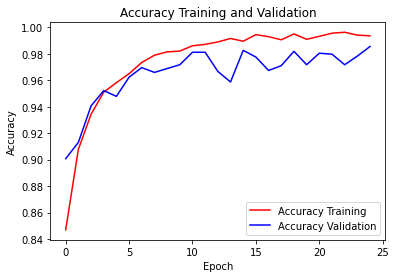

In [16]:
plt.plot(history.history['accuracy'], 'r', label='Accuracy Training')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy Validation')
plt.title('Accuracy Training and Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

In [17]:
score = model.evaluate(valid_gen)
print(f'Accuracy Score = {round(score[1], 2) * 100}%')

44/44 [==============================] - 4s 99ms/step - loss: 0.0722 - accuracy: 0.9797
Accuracy Score = 98.0%


#### Calculate confusion matrix, precision, recall, f1

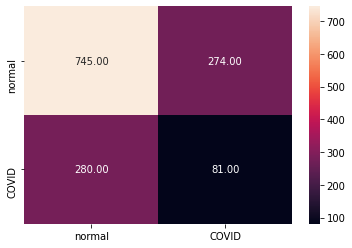

In [18]:
y_true = valid_gen.classes
y_pred = model.predict(valid_gen)
y_pred = y_pred.reshape(-1)
y_pred = y_pred > 0.5
cf = confusion_matrix(y_true, y_pred)
sns.heatmap(cf, xticklabels=classes, yticklabels=classes, annot=True, fmt='.2f');

In [19]:
report = classification_report(y_true, y_pred, target_names=classes)
print(report)

              precision    recall  f1-score   support

      normal       0.73      0.73      0.73      1019
       COVID       0.23      0.22      0.23       361

    accuracy                           0.60      1380
   macro avg       0.48      0.48      0.48      1380
weighted avg       0.60      0.60      0.60      1380



#### ROC-AUC curve and AUC score

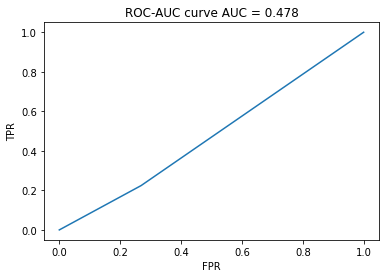

In [20]:
fpr, tpr, thresh = roc_curve(y_true, y_pred)
auc_score = round(roc_auc_score(y_true, y_pred), 3)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f'ROC-AUC curve AUC = {auc_score}')
plt.show()

#### Calculate Accuracy, Sensitivity, specificity, and PPV
Calculate PPV (Positive Predictive Value) using Bayes Theorem
 
 
$$ PPV = \frac{sensitivity \times prevalence}{sensitivity\times prevalence + (1 - specificty)\times(1 - prevalence)} $$

In [21]:
# tp, fp, tn, fn
tp = np.sum((y_true == 1) & (y_pred == 1))
fp = np.sum((y_true == 0) & (y_pred == 1))
tn = np.sum((y_true == 0) & (y_pred == 0))
fn = np.sum((y_true == 1) & (y_pred == 0))

# sensitivity, specificity
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f'Accuracy = {round(accuracy * 100, 2)}%')
print(f'Sensitivity = {round(sensitivity * 100, 2)}%')
print(f'Specificity = {round(specificity * 100, 2)}%')
    
# Calculate PPV according to Bayes Theorem
prev = np.sum(y_true) / len(y_true)
numerator = sensitivity * prev
denominator = sensitivity * prev + (1 - specificity) * (1 - prev)
ppv = numerator / denominator
print(f'Positive Predictive Value = {round(ppv * 100, 2)}%')


Accuracy = 59.86%
Sensitivity = 22.44%
Specificity = 73.11%
Positive Predictive Value = 22.82%


$$ P^4 $$ 
#### (Pretty Piss Poor Performance)

But it is a baseline, and we are getting the metrics to be used worked out.